## Homework 2: House Prices, Advanced Regression Techniques
### Neal Bangerter
### Applied Machine Learning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import SGDRegressor, LassoCV, ElasticNetCV, RidgeCV, HuberRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model

I'll start by reading in the testing and training data and trying to get a feel for what the data looks like.

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
full = train
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
len(train)

1460

At this point, I'm more concerned with the training data, since that's what I'll primarily be working with. It looks like there are 79 different variables (a mix of numerical and categorical data) and 1460 entries. I'll start by dropping the Id column because it won't help with a regression, and pulling aside the SalePrice column so I can later use it as my target variable in the regressions. Also, two of the variables (MSSubClass and MoSold) should be categorical, but are entered as numbers, so I'll convert them both to strings so pandas doesn't try to interpret them as numerical. (Months are categorical because it's continuous from 12 to 1: running a regression numerically on this column would produce nonsensical results).

Throughout the data cleaning process, I'll be echoing everything I do to the training dataset on the testing dataset to ensure they stay in the same format. 

In [5]:
target = train.SalePrice
train = train.drop('SalePrice', axis=1)
train = train.drop('Id', axis=1)
train.MSSubClass = train.MSSubClass.astype(str) #convert MSSubClass to a string
train.MoSold = train.MoSold.astype(str) #convert MoSold to a string

In [6]:
test = test.drop('Id',axis=1)
test.MSSubClass = test.MSSubClass.astype(str)
test.MoSold = test.MoSold.astype(str)

For easy manipulation of the data, I'll create a list of the categorical and the numerical columns from my data frames, since a lot of the cleaning and analysis will be different for the different sorts of variables.

In [7]:
categorical = list(train.select_dtypes(include=['object']))
numerical = list(train.select_dtypes(exclude=['object']))

Some of the variables have null values entered; for some of the columns, a null value is actually indicative of that object not being present in the house, so some of the columns should probably have a pretty high null value count.

In [8]:
null_values = train.isnull().sum()

print("Categorical Variables:\n")

for var in categorical:
    if null_values[var] != 0:
        print(var, null_values[var])
   
print("\nNumerical Variables:\n")

for var in numerical:
    if null_values[var] != 0:
        print(var, null_values[var])

Categorical Variables:

Alley 1369
MasVnrType 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406

Numerical Variables:

LotFrontage 259
MasVnrArea 8
GarageYrBlt 81


To fill null values, I decided to use the most common entry for the categorical data, 'None' where the null has meaning, and fill the numerical data with either 0 for variables that that made sense, and the mean of the column for variables where 0 would be nonsensical. I used the training dataset for both the training and test datasets because that seemed to make the most sense, given that I'll be using the training dataset to calculate my regressions.

In [9]:
print('MasVnrType:\n', train['MasVnrType'].value_counts(), '\n')
print('Electrical:\n', train['Electrical'].value_counts())

MasVnrType:
 None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64 

Electrical:
 SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


In [10]:
#categorical data is replaced with either 'None' or the most common value, depending on which makes more sense
train.loc[train['Alley'].isnull(),'Alley'] = "None"
train.loc[train['MasVnrType'].isnull(),'MasVnrType'] = "None"
train.loc[train['BsmtQual'].isnull(),'BsmtQual'] = "None"
train.loc[train['BsmtCond'].isnull(),'BsmtCond'] = "None"
train.loc[train['BsmtExposure'].isnull(),'BsmtExposure'] = "None"
train.loc[train['BsmtFinType1'].isnull(),'BsmtFinType1'] = "None"
train.loc[train['BsmtFinType2'].isnull(),'BsmtFinType2'] = "None"
train.loc[train['Electrical'].isnull(),'Electrical'] = "SBrkr"
train.loc[train['FireplaceQu'].isnull(),'FireplaceQu'] = "None"
train.loc[train['GarageType'].isnull(),'GarageType'] = "None"
train.loc[train['GarageFinish'].isnull(),'GarageFinish'] = "None"
train.loc[train['GarageQual'].isnull(),'GarageQual'] = "None"
train.loc[train['GarageCond'].isnull(),'GarageCond'] = "None"
train.loc[train['PoolQC'].isnull(),'PoolQC'] = "None"
train.loc[train['Fence'].isnull(),'Fence'] = "None"
train.loc[train['MiscFeature'].isnull(),'MiscFeature'] = "None"

#numeric data is replaced with either 0 or the mean of the training data in that column
train.loc[train['LotFrontage'].isnull(),'LotFrontage'] = train['LotFrontage'].mean()
train.loc[train['MasVnrArea'].isnull(),'MasVnrArea'] = 0
train.loc[train['GarageYrBlt'].isnull(),'GarageYrBlt'] = train['GarageYrBlt'].mean()

In [11]:
null_values = test.isnull().sum() #get sums of null values in each column

#iterate over and print values for variables that have null values
print("Categorical Variables:\n")

for var in categorical:
    if null_values[var] != 0:
        print(var, null_values[var])
   
print("\nNumerical Variables:\n")

for var in numerical:
    if null_values[var] != 0:
        print(var, null_values[var])

Categorical Variables:

MSZoning 4
Alley 1352
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 16
BsmtQual 44
BsmtCond 45
BsmtExposure 44
BsmtFinType1 42
BsmtFinType2 42
KitchenQual 1
Functional 2
FireplaceQu 730
GarageType 76
GarageFinish 78
GarageQual 78
GarageCond 78
PoolQC 1456
Fence 1169
MiscFeature 1408
SaleType 1

Numerical Variables:

LotFrontage 227
MasVnrArea 15
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 78
GarageCars 1
GarageArea 1


In [12]:
print('MSZoning:\n', train['MSZoning'].value_counts(), '\n')
print('Utilities:\n', train['Utilities'].value_counts(), '\n')
print('Exterior1st:\n', train['Exterior1st'].value_counts(), '\n')
print('Exterior2nd:\n', train['Exterior2nd'].value_counts(), '\n')
print('KitchenQual:\n', train['KitchenQual'].value_counts(), '\n')
print('Functional:\n', train['Functional'].value_counts(), '\n')
print('SaleType:\n', train['SaleType'].value_counts(), '\n')

MSZoning:
 RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64 

Utilities:
 AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64 

Exterior1st:
 VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
CBlock       1
ImStucc      1
Name: Exterior1st, dtype: int64 

Exterior2nd:
 VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64 

KitchenQual:
 TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64 

Functional:
 Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64 

SaleType:
 WD     

In [13]:
#categorical data is replaced with either 'None' or the most common value, depending on which makes more sense
test.loc[test['Alley'].isnull(),'Alley'] = "None"
test.loc[test['MasVnrType'].isnull(),'MasVnrType'] = "None"
test.loc[test['BsmtQual'].isnull(),'BsmtQual'] = "None"
test.loc[test['BsmtCond'].isnull(),'BsmtCond'] = "None"
test.loc[test['BsmtExposure'].isnull(),'BsmtExposure'] = "None"
test.loc[test['BsmtFinType1'].isnull(),'BsmtFinType1'] = "None"
test.loc[test['BsmtFinType2'].isnull(),'BsmtFinType2'] = "None"
test.loc[test['Electrical'].isnull(),'Electrical'] = "SBrkr"
test.loc[test['FireplaceQu'].isnull(),'FireplaceQu'] = "None"
test.loc[test['GarageType'].isnull(),'GarageType'] = "None"
test.loc[test['GarageFinish'].isnull(),'GarageFinish'] = "None"
test.loc[test['GarageQual'].isnull(),'GarageQual'] = "None"
test.loc[test['GarageCond'].isnull(),'GarageCond'] = "None"
test.loc[test['PoolQC'].isnull(),'PoolQC'] = "None"
test.loc[test['Fence'].isnull(),'Fence'] = "None"
test.loc[test['MiscFeature'].isnull(),'MiscFeature'] = "None"
test.loc[test['MSZoning'].isnull(),'MSZoning'] = "RL"
test.loc[test['Utilities'].isnull(),'Utilities'] = "AllPub"
test.loc[test['Exterior1st'].isnull(),'Exterior1st'] = "VinylSd"
test.loc[test['Exterior2nd'].isnull(),'Exterior2nd'] = "VinylSd"
test.loc[test['KitchenQual'].isnull(),'KitchenQual'] = "TA"
test.loc[test['Functional'].isnull(),'Functional'] = "Typ"
test.loc[test['SaleType'].isnull(),'SaleType'] = "WD"

#numeric data is replaced with either 0 or the mean of the training data in that column
test.loc[test['LotFrontage'].isnull(),'LotFrontage'] = train['LotFrontage'].mean()
test.loc[test['MasVnrArea'].isnull(),'MasVnrArea'] = 0
test.loc[test['GarageYrBlt'].isnull(),'GarageYrBlt'] = train['GarageYrBlt'].mean()
test.loc[test['BsmtFinSF1'].isnull(),'BsmtFinSF1'] = 0
test.loc[test['BsmtFinSF2'].isnull(),'BsmtFinSF2'] = 0
test.loc[test['BsmtUnfSF'].isnull(),'BsmtUnfSF'] = 0
test.loc[test['TotalBsmtSF'].isnull(),'TotalBsmtSF'] = 0
test.loc[test['BsmtFullBath'].isnull(),'BsmtFullBath'] = 0
test.loc[test['BsmtHalfBath'].isnull(),'BsmtHalfBath'] = 0
test.loc[test['GarageCars'].isnull(),'GarageCars'] = 0
test.loc[test['GarageArea'].isnull(),'GarageArea'] = 0

Because the numerical data varies in scale enormously, I'll be scaling the data using the standard scaler. Again, I'll be using the training dataset to fit the scaler because I'll need it to be consistent across both datasets. Printing out the head of each dataset as a sanity check to make sure everything's looking good through here.

In [14]:
scaler = StandardScaler()
scaler.fit(train[numerical]) #fit the scaler to the numerical entries in train
train[numerical] = scaler.transform(train[numerical])
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,-0.229372,-0.207142,Pave,None,Reg,Lvl,AllPub,Inside,...,-0.270208,-0.068692,None,None,None,-0.087688,2,0.138777,WD,Normal
1,20,RL,0.451936,-0.091886,Pave,None,Reg,Lvl,AllPub,FR2,...,-0.270208,-0.068692,None,None,None,-0.087688,5,-0.614439,WD,Normal
2,60,RL,-0.093110,0.073480,Pave,None,IR1,Lvl,AllPub,Inside,...,-0.270208,-0.068692,None,None,None,-0.087688,9,0.138777,WD,Normal
3,70,RL,-0.456474,-0.096897,Pave,None,IR1,Lvl,AllPub,Corner,...,-0.270208,-0.068692,None,None,None,-0.087688,2,-1.367655,WD,Abnorml
4,60,RL,0.633618,0.375148,Pave,None,IR1,Lvl,AllPub,FR2,...,-0.270208,-0.068692,None,None,None,-0.087688,12,0.138777,WD,Normal


In [15]:
test[numerical] = scaler.transform(test[numerical])
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,0.451936,0.110763,Pave,None,Reg,Lvl,AllPub,Inside,...,1.882709,-0.068692,None,MnPrv,None,-0.087688,6,1.64521,WD,Normal
1,20,RL,0.497357,0.375850,Pave,None,IR1,Lvl,AllPub,Corner,...,-0.270208,-0.068692,None,None,Gar2,25.116309,6,1.64521,WD,Normal
2,60,RL,0.179413,0.332053,Pave,None,IR1,Lvl,AllPub,Inside,...,-0.270208,-0.068692,None,MnPrv,None,-0.087688,3,1.64521,WD,Normal
3,60,RL,0.361095,-0.054002,Pave,None,IR1,Lvl,AllPub,Inside,...,-0.270208,-0.068692,None,None,None,-0.087688,6,1.64521,WD,Normal
4,120,RL,-1.228623,-0.552407,Pave,None,IR1,HLS,AllPub,Inside,...,2.313293,-0.068692,None,None,None,-0.087688,1,1.64521,WD,Normal


I've decided pulling out outliers doesn't seem like a good idea, given that an outlier in any given category is likely to be caused by something from the 78 other categories. It seems more likely that I'll delete valuable information than that I'll actually get rid of something useful, so I'm not going to worry about trying to identify valid outliers and delete them out. 

Now that I've cleaned the data, I'm going to look over my target (SalePrice) data and make sure everything makes sense. Specifically, I'm looking for reasonable minimum and maximum values, a reasonable distribution, and no missing values. 

In [16]:
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [17]:
target.isnull().sum()

0

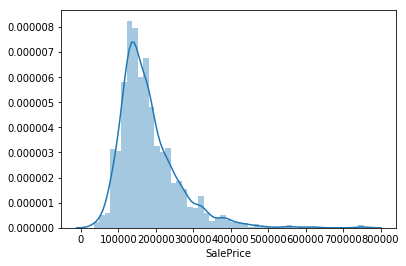

In [18]:
sns.distplot(target)

Nice! That looks just about perfect. No missing or unreasonable values, and a distribution with a skew right. A log transformation fixes the skew and gets the distribution ot closely approximate the normal distribution, but it didn't seem to help out with regression at all when I included it, so I've left it out here in the interest of space.

I'll be looking for correlations in my data now, looking for the variables that seem to correlate most with SalePrice. I've included heatmaps for the correlations of the numeric values; I also created boxplots for all of the categorical variables, but that was too obscenely long to include.

Fortunately, none of the numeric variables are perfectly correlated with other variables, so the regressions should be alright. Some of the variables are highly correlated with one another (GarageCars and GarageArea, for example), so I can consider pulling some of them out of the final regression if it seems like it'll help.

Text(0.5,1.05,'Correlation Matrix Heatmap')

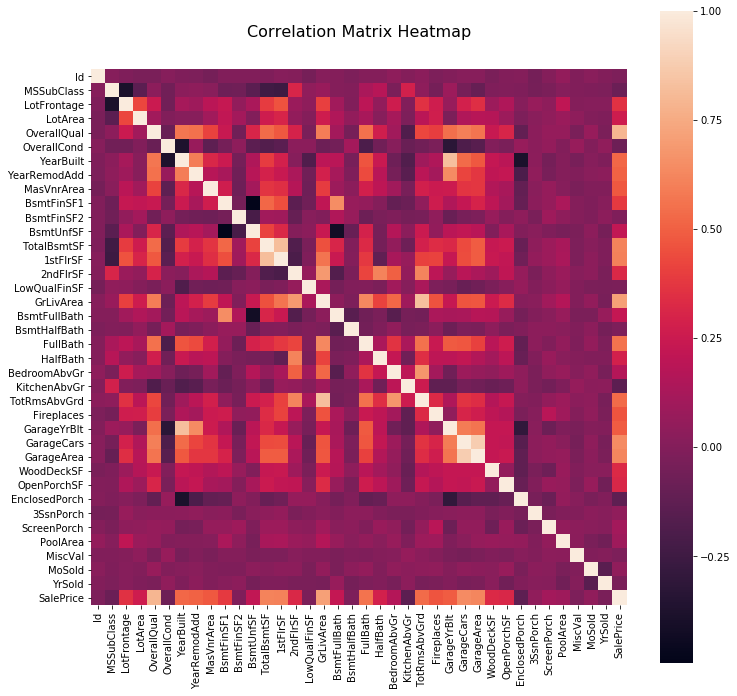

In [19]:
#create a heatmap of all numeric values
plt.subplots(figsize = (12,12))
sns.heatmap(full.corr(), square=True)
plt.title('Correlation Matrix Heatmap', fontsize=16, y=1.05)

Text(0.5,1.05,'Correlation Matrix Heatmap - Top 12')

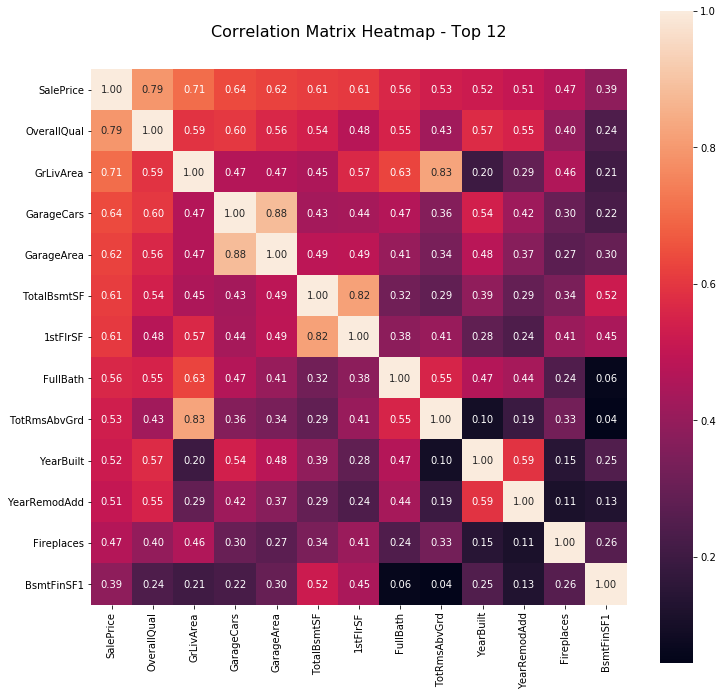

In [20]:
#create a heatmap showing the correlation values for the 12 variables that most correlate with SalePrice
cols = (full.corr()).nlargest(15, 'SalePrice')['SalePrice'].index
cols = cols[0:11].append(cols[13:15])
top_corr = np.corrcoef(full[cols].values.T)

plt.subplots(figsize = (12,12))
sns.heatmap(top_corr, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('Correlation Matrix Heatmap - Top 12', fontsize=16, y=1.05)

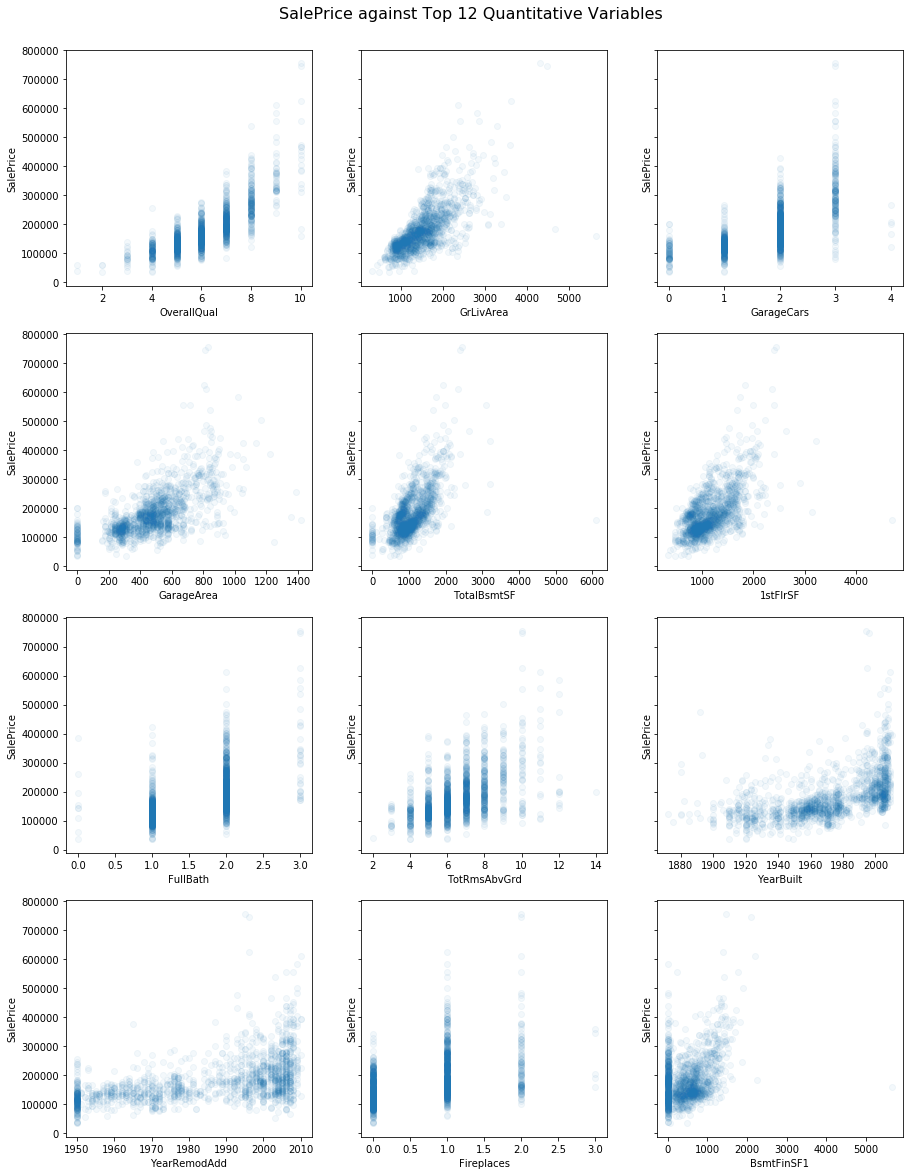

In [21]:
#scatter plots of the 12 numerical variables that most correlate with SalePrice
fig, axes = plt.subplots(4, 3, figsize=(15,20), sharey='all')

fig.suptitle('SalePrice against Top 12 Quantitative Variables', fontsize=16, y=0.91)

#iterate through the 12 variables and create the charts
for i, ax in enumerate(axes.flat):
    ax.scatter(y=full.SalePrice, x=full[cols[i+1]], alpha = 0.05)
    ax.set_xlabel(cols[i+1]) #i+1 skips the SalePrice column, since it technically is the most correlated with SalePrice
    ax.set_ylabel('SalePrice')

The above charts show the twelve numeric variables that most correlate with SalePrice. Several of the variables look like they could be better approximated with polynomial forms instead of linear approximations, but when I attempted to include polynomial relationships in my regressions, the regressions' RMSE shot up, so after all that work examining my numeric data, it didn't end up influencing my final regressions. Similarly, I tried stripping my regressions down to only the categorical data that appeared to most influence SalePrice, but it again only made the models less accurate, so I didn't end up including any of that information.

Now that I've finished cleaning the base data, I'll break out the categorical data into dummies and make sure that the columns in both the training and testing data match. Because any dummy column that's only in either my testing or my training data set won't be useful for making predictions on the testing dataset, I'll delete out any columns that aren't in both datasets.

In [22]:
#get dummy variables for categorical data in train
train = pd.get_dummies(train)
train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,...,0,0,0,1,0,0,0,0,1,0
1,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,...,0,0,0,1,0,0,0,0,1,0
2,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,...,0,0,0,1,0,0,0,0,1,0
3,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,...,0,0,0,1,1,0,0,0,0,0
4,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,-0.174865,...,0,0,0,1,0,0,0,0,1,0


In [23]:
#get dummy variables for categorical data in test
test = pd.get_dummies(test)

In [24]:
#identify columns in train not found in test
train.columns.difference(test.columns)

Index(['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'GarageQual_Ex', 'Heating_Floor', 'Heating_OthW',
       'HouseStyle_2.5Fin', 'MiscFeature_TenC', 'PoolQC_Fa',
       'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'Utilities_NoSeWa'],
      dtype='object')

In [25]:
#identify columns in test not found in train
test.columns.difference(train.columns)

Index(['MSSubClass_150'], dtype='object')

In [26]:
#drop columns from train not found in test
for col in train.columns.difference(test.columns):
    train = train.drop(col, axis=1)
    
train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,...,0,0,0,1,0,0,0,0,1,0
1,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,...,0,0,0,1,0,0,0,0,1,0
2,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,...,0,0,0,1,0,0,0,0,1,0
3,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,...,0,0,0,1,1,0,0,0,0,0
4,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,-0.174865,...,0,0,0,1,0,0,0,0,1,0


In [27]:
#drop columns from test not found in train
for col in test.columns.difference(train.columns):
    test = test.drop(col, axis=1)
    
test.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.451936,0.110763,-0.795151,0.381743,-0.340077,-1.156380,-0.570750,0.053428,0.604293,-0.672923,...,0,0,0,1,0,0,0,0,1,0
1,0.497357,0.375850,-0.071836,0.381743,-0.439440,-1.301740,0.027027,1.051363,-0.288653,-0.365032,...,0,0,0,1,0,0,0,0,1,0
2,0.179413,0.332053,-0.795151,-0.517200,0.852269,0.636400,-0.570750,0.761852,-0.288653,-0.974021,...,0,0,0,1,0,0,0,0,1,0
3,0.361095,-0.054002,-0.071836,0.381743,0.885390,0.636400,-0.460051,0.347326,-0.288653,-0.550672,...,0,0,0,1,0,0,0,0,1,0
4,-1.228623,-0.552407,1.374795,-0.517200,0.686666,0.345679,-0.570750,-0.396190,-0.288653,1.018211,...,0,0,0,1,0,0,0,0,1,0


Now that all my data is ready for modeling, I'm going to break the training data into two to cross validate each of the models I try. Given that I'm trying to estimate continuous values, I'll stick to regression. I could change it to a categorization problem by bucketing the data and trying to estimate the data that way, but my guess is I'll be able to get a much better estimate with regression models.

The first model I'll try is a standard SGDRegressor, which I'll use to benchmark all the other models I do.

In [28]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)

In [29]:
#fit the model
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
linear_regression_model.fit(X_train, y_train)

#predict values
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

#calculate MSE
train_mse = mean_squared_error(np.log(y_train), np.log(train_predictions))
test_mse = mean_squared_error(np.log(y_test), np.log(test_predictions))

#output RMSE. The code is essentially identical in each of the below regressions.
print("Train RMSE: {}".format(np.sqrt(train_mse)))
print("Test RMSE: {}".format(np.sqrt(test_mse)))

Train RMSE: 0.13842662502299835
Test RMSE: 0.1609600156934694


In [30]:
param_dist = {'eta0': [.001, .003, .01, .03, .1, .3, 1, 3], 'tol': [.0001, .0003, .001, .003, .01, .03, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor()
n_iter_search = 12

random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

train_predictions = random_search.predict(X_train)
test_predictions = random_search.predict(X_test)

train_mse = mean_squared_error(np.log(y_train), np.log(train_predictions))
test_mse = mean_squared_error(np.log(y_test), np.log(test_predictions))

print("Best Parameters: {}".format(random_search.best_params_))
print("Train RMSE: {}".format(np.sqrt(train_mse)))
print("Test RMSE: {}".format(np.sqrt(test_mse)))

Best Parameters: {'tol': 0.0001, 'eta0': 0.001}
Train RMSE: 0.14195666329941656
Test RMSE: 0.16155990562038822


Cross-Validation of the parameters didn't help much. It gave me marginally better RMSE, but didn't make much of a difference at all. The main issue I'm probably running into probably isn't high variance, but it's worth giving models that help control for high variance a shot anyway. To regularize the model, I'll Lasso, Ridge, and Elastic Net models cross validating across a number of parameters:

In [31]:
ridge = RidgeCV(alphas=[0.1,1,10,100,500,1000])

ridge.fit(X_train, y_train)

train_predictions = ridge.predict(X_train)
test_predictions = ridge.predict(X_test)

train_mse = mean_squared_error(np.log(y_train), np.log(train_predictions))
test_mse = mean_squared_error(np.log(y_test), np.log(test_predictions))

print("Train RMSE: {}".format(np.sqrt(train_mse)))
print("Test RMSE: {}".format(np.sqrt(test_mse)))

Train RMSE: 0.12286846428232162
Test RMSE: 0.16265107979802088


In [32]:
lasso = LassoCV(alphas=[0.1,1,10,100,500,1000], max_iter=1000000)

lasso.fit(X_train, y_train)

train_predictions = lasso.predict(X_train)
test_predictions = lasso.predict(X_test)

train_mse = mean_squared_error(np.log(y_train), np.log(train_predictions))
test_mse = mean_squared_error(np.log(y_test), np.log(test_predictions))

print("Train RMSE: {}".format(np.sqrt(train_mse)))
print("Test RMSE: {}".format(np.sqrt(test_mse)))

Train RMSE: 0.14008635054045937
Test RMSE: 0.15701918341422763


In [33]:
elastic_net = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[0.1,1,10,100,500,1000], max_iter=1000000)

elastic_net.fit(X_train, y_train)

train_predictions = elastic_net.predict(X_train)
test_predictions = elastic_net.predict(X_test)

train_mse = mean_squared_error(np.log(y_train), np.log(train_predictions))
test_mse = mean_squared_error(np.log(y_test), np.log(test_predictions))

print("Train RMSE: {}".format(np.sqrt(train_mse)))
print("Test RMSE: {}".format(np.sqrt(test_mse)))

Train RMSE: 0.1420445423092527
Test RMSE: 0.15513642071004904


All 3 of the models performed better than the simple regression; Ridge had the best training RMSE, but also had the highest testing RMSE, indicating that it probably won't be good for actual estimation. Elastic Net and Lasso both suffer from the same issue to a smaller extent, but improve marginally on Ridge's testing RMSE. Elastic Net is the best I've got so far, but it doesn't perform much better than any of the others. 

My guess is that the primary issue I'm running into is outliers pulling my models off a bit, since I decided against attempting to identify outliers. After looking for models that are at least somewhat outlier-robust, I decided to try the Huber Regressor, which ended up performing significantly better than any of the previous models I'd fit. I submitted to Kaggle my predictions from the elastic net, a combination model I threw together, and the Huber Regressor, and the Huber Regressor ended up giving me far and away the highest ranking. 

In [34]:
Huber = HuberRegressor(alpha=0.001, max_iter=1000000)

Huber.fit(X_train, y_train)

train_predictions = Huber.predict(X_train)
test_predictions = Huber.predict(X_test)

train_mse = mean_squared_error(np.log(y_train), np.log(train_predictions))
test_mse = mean_squared_error(np.log(y_test), np.log(test_predictions))

print("Train RMSE: {}".format(np.sqrt(train_mse)))
print("Test RMSE: {}".format(np.sqrt(test_mse)))

Train RMSE: 0.11962613300041791
Test RMSE: 0.13495531129303745


Text(0.5,0,'Actual Values')

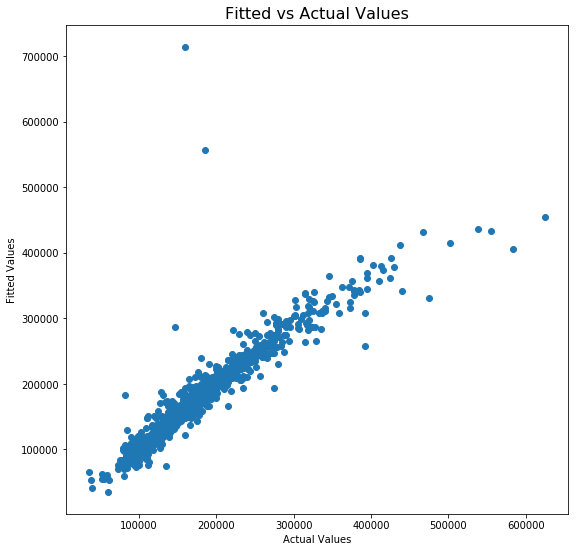

In [35]:
plt.subplots(figsize=(9,9))
plt.scatter(y_train, train_predictions)
plt.ylim=(0,700000)
plt.xlim=(0,700000)
plt.title('Fitted vs Actual Values', fontsize=16)
plt.ylabel('Fitted Values')
plt.xlabel('Actual Values')

The above chart isn't super intuitive, but it does provide some valuable data about the behavior of my model. Ideally, the dots would map a perfect line from the bottom left corner to the top right corner, and the closer the dots are to that line, the better the fit of my model. There are a couple of crazy outliers, mostly clustered around the actual value of 200,000. The biggest failure of my model is its consistent undervaluing of the higher value homes. I attempted to rectify this by running a second regression on values that I estimated over 300,000 to try to better match the upper values, but it ended up destroying my model and not working very well, probably because there are too few data points for me to get a very accurate regression.

I'm pleased with how the modeling in this assignment went, but in all honesty, I think I'd probably not recommend the use of my model in industry. It does pretty well for the lower values with a couple of notable exceptions, but once it gets to higher values of houses, my model serially underestimates the values of the properties, which would be a serious shortcoming for any business. I'd need to tweak my model significantly to get it to a level of accuracy where it could realistically be used to estimate house prices in any meaningful situation.

### Prepare Kaggle Submission

In [36]:
kaggle_predictions = Huber.predict(test) #get the predictions from my Huber model

In [37]:
#get the index numbers for the testing dataset
index = pd.read_csv('test.csv')
index = index.Id

submission = pd.DataFrame(index, kaggle_predictions)
for i in range(0, len(submission)):
    submission.Id[i] = int(i + 1461) #adding the index automatically wasn't working for me, so I just added it manually.

submission.to_csv('submission.csv') #write to CSV